In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import *
from matplotlib.pyplot import figure

In [7]:
tf_config = K.tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
session = K.tf.Session(config=tf_config)
K.set_session(session)

In [8]:
import pandas as pd
df = pd.read_csv ('/data/Data/yntn/data_labeled_10M.csv')

In [9]:
label_tag = (list(set (df.label)))
label_tag.sort()
cutdata = []
for i in range (len(label_tag)):
    df_go = df[df.label == label_tag[i]].head(350000)
    cutdata.append(df_go)

In [10]:
df = pd.concat(cutdata, axis = 0)

Text(0.5, 0, 'Label')

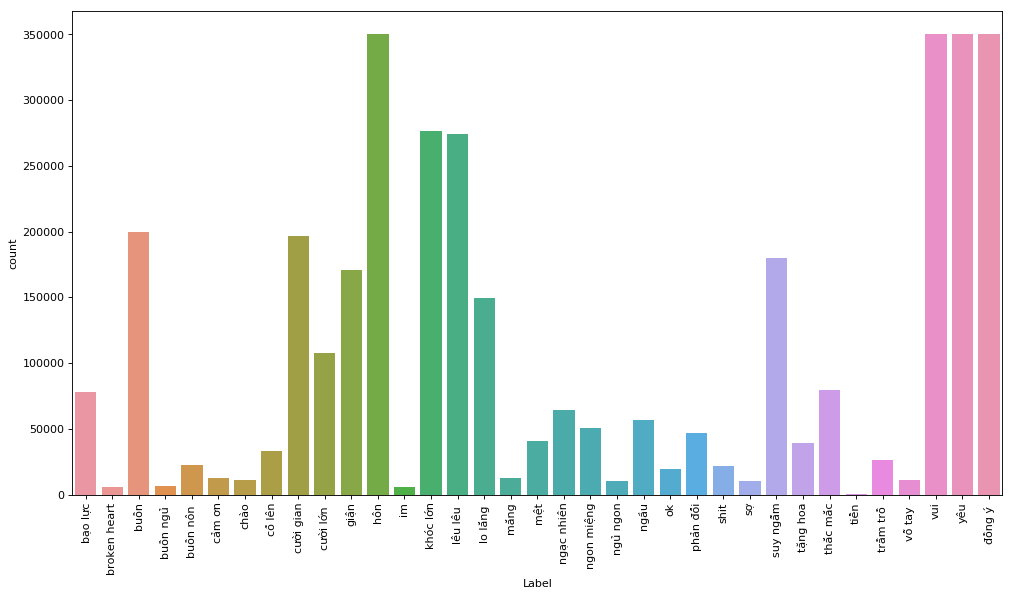

In [11]:
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
sns.countplot(df.label)
plt.xlabel('Label')

In [12]:
X = df.text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)

In [13]:
onehot_Y = []

for i in range(len(Y)):
    tmp = []
    tmp = [ 0 for i in range(0, 35)] # set all 0
    tmp[Y[i]] = 1 
    onehot_Y.append(tmp)

In [14]:
Y = np.array(onehot_Y)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11)

# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=11)

In [16]:
max_len = 30
max_words = 88860
tok = Tokenizer(num_words = max_words)
X_train = [str(s) for s in X_train]
tok.fit_on_texts(X_train)

max_words = len(tok.index_word)+1

sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [17]:
pickle.dump(tok, open('tokenize.pkl','wb'))

In [18]:
word_dict = pickle.load (open("/data/Data/yntn/word_embedding_vec.pkl",'rb'))

In [19]:
w = np.random.normal(0, 1, (max_words, 300))

In [20]:
for i in range (1, max_words):
    if (tok.index_word[i] in word_dict):
        w[i] = word_dict[tok.index_word[i]]

In [21]:
def RNN():
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(max_words, 300, input_length = max_len, weights = [w])(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(35,name = 'out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs = inputs,outputs = layer)
    return model

In [22]:
model  = RNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           25647600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 35)                8995      
__________

In [23]:
# Compatible with tensorflow backend
import tensorflow as tf
# def focal_loss(gamma=10, alpha=.25):
def focal_loss(gamma=10, alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [24]:
# model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(),metrics = ['accuracy'])

## focal loss
model.compile(loss=[focal_loss(alpha=.25, gamma=10)], metrics=["accuracy"], optimizer='adam')

In [25]:
weight_file = "model_LSTM_w12_st4_head350_focal_loss.hdf5"
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
    ModelCheckpoint(weight_file, monitor = 'val_loss', verbose = 1, save_best_only = True)
]

In [26]:
history = model.fit(sequences_matrix,Y_train,batch_size = 2048, epochs = 10,
          validation_split = 0.2, callbacks = callbacks)

Train on 2317564 samples, validate on 579392 samples
Epoch 1/10
2317564/2317564 [==============================] - 89s 39us/step - loss: 0.0099 - acc: 0.2193 - val_loss: 0.0091 - val_acc: 0.2465

Epoch 00001: val_loss improved from inf to 0.00910, saving model to model_LSTM_w12_st4_head350_focal_loss.hdf5
Epoch 2/10
2317564/2317564 [==============================] - 87s 38us/step - loss: 0.0091 - acc: 0.2453 - val_loss: 0.0089 - val_acc: 0.2540

Epoch 00002: val_loss improved from 0.00910 to 0.00891, saving model to model_LSTM_w12_st4_head350_focal_loss.hdf5
Epoch 3/10
2317564/2317564 [==============================] - 87s 38us/step - loss: 0.0089 - acc: 0.2513 - val_loss: 0.0088 - val_acc: 0.2567

Epoch 00003: val_loss improved from 0.00891 to 0.00883, saving model to model_LSTM_w12_st4_head350_focal_loss.hdf5
Epoch 4/10
2317564/2317564 [==============================] - 87s 38us/step - loss: 0.0088 - acc: 0.2546 - val_loss: 0.0088 - val_acc: 0.2584

Epoch 00004: val_loss improved fro

In [27]:
X_test = [str(s) for s in X_test]
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)

724240/724240 [==============================] - 414s 572us/step


In [28]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.009
  Accuracy: 0.261


In [29]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.009
  Accuracy: 0.261


100MB LTSM
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(),metrics = ['accuracy'])

In [30]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.009
  Accuracy: 0.261
